In [1]:
import torch 

import numpy as np

import h5py as h5

import json

import argparse

import itertools

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import matplotlib.lines as mlines

from pathlib import Path

from qcdanalysistools.analysis import dataAnalysis, AnalysisParam, Bootstrap

import isle

from Misc import get_fn, read_params, make_action, overview

from ML_Layer import RealLinearTransformation, Coupling, Equivariance, PRCL, Sequential

from ML_Data import TrainDataset

from ML_Training import cross_validation, train

from Analysis import field_statistic, estimate_correlators

from HMC import ML_HMC, HMC

from Correlators import measure_correlators

In [2]:
import isle.plotting
isle.plotting.setupMPL()

# define FZJ cooperate colors
BLUE      = (  2/255, 61/255,107/255)
LIGHTBLUE = (173/255,189/255,227/255)
GRAY      = (235/255,235/255,235/255)
RED       = (235/255, 95/255,115/255)
GREEN     = (185/255,210/255, 95/255)
YELLOW    = (250/255,235/255, 90/255)
VIOLET    = (175/255,130/255,185/255)
ORANGE    = (250/255,180/255, 90/255)
WHITE     = (255/255,255/255,255/255)

In [3]:
# The model for the 2 site is to small for gpu.
torch_options = {
    "use_gpu": False,#torch.cuda.is_available(),
    "dtype": torch.double,
    "device": torch.device("cpu")
}

torch.set_default_tensor_type(torch.DoubleTensor)


dataLoader_options = {'num_workers': 1, 'pin_memory': True} if torch_options['use_gpu'] else {}

if torch_options['use_gpu']:
    torch.multiprocessing.set_start_method('spawn')

In [13]:
param_path = "ParameterFiles/2Site_flow1e-1.json"
params = read_params(param_path)

print(f"Read from {param_path}")
for key,val in params.asdict().items():
    print(f"{key: <15}: {val}")

Read from ParameterFiles/2Site_flow1e-1.json
nt             : 32
lattice        : two_sites
beta           : 4.0
U              : 4.0
mu             : 3.0
tangent_plane  : -0.249966501
tau_f          : 0.1
lr             : 0.0005
epochs         : 100
mini_batches   : 1
number_layers  : 2
rng_seed       : 1075
exact_corr_path: ExactData/exact.two_sites.exp.nt128.beta4_0.U4_0.mu3_0.txt
volume         : 64
sigmaKappa     : -1
hopping        : HFAHopping.EXP
basis          : HFABasis.PARTICLE_HOLE
algorithm      : HFAAlgorithm.DIRECT_SINGLE


In [14]:

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, fns, param):
        super(TrainDataset, self).__init__()

        Nt = param['nt']

        if param['lattice'] == "two_sites":
            Nx = 2
        else:
            raise RuntimeError( f"TrainDataset not implemented for lattice: {param['lattice']}" )
        
        self.size = 0
        
        self.raw_action = []
        self.raw = []
        self.raw_flowed_action = []
        self.raw_flowed = []
        
        for f in fns:
            fn = Path(f"TrainingData/TrainingData.flow{f}.two_sites.exp.nt32.beta4_0.U4_0.mu3_0.h5")
            with h5.File(fn) as h5f:
                self.raw_action.append(torch.from_numpy(
                    h5f[f"TrainData/TP_action"][()],
                ))
                self.raw_flowed_action.append(torch.from_numpy(
                    h5f[f"TrainData/flow_{float(f):.2e}/TP_action"][()],
                ))

                Nconf = 10000
                self.raw.append(torch.from_numpy(
                    h5f[f"TrainData/TP_conf"][()],
                ).reshape(Nconf,Nt,Nx))
                self.raw_flowed.append(torch.from_numpy(
                    h5f[f"TrainData/flow_{float(f):.2e}/TP_conf"][()],
                ).reshape(Nconf,Nt,Nx))

            self.size += Nconf
        self.raw_action = torch.cat(tuple(self.raw_action),dim=0)
        self.raw = torch.cat(tuple(self.raw),dim=0)
        self.raw_flowed_action = torch.cat(tuple(self.raw_flowed_action),dim=0)
        self.raw_flowed = torch.cat(tuple(self.raw_flowed),dim=0)  
        

    def to(self,*args,**kwargs):
        self.raw = self.raw.to(*args,**kwargs)
        self.raw_action = self.raw_action.to(*args,**kwargs)
        self.raw_flowed = self.raw_flowed.to(*args,**kwargs)
        self.raw_flowed_action = self.raw_flowed_action.to(*args,**kwargs)

        return self

    def __len__(self):
        return self.size

    def __getitem__(self, item):
        return self.raw[item,:], self.raw_flowed[item,:]

    def getAction(self,item):
        return self.raw_action[item], self.raw_flowed_action[item]

In [15]:
%time

dtSet = TrainDataset(
    fns = ["1e-01", "1e-02", "1e-03", "1e-06"],
    param = params,
)

Ntrain = int(0.9*len(dtSet))
Nvalid = int(0.1*len(dtSet))
N = Ntrain+Nvalid

train_dataLoader = torch.utils.data.DataLoader(
    dtSet,
    batch_size=Ntrain//params['mini_batches'],
    sampler=range(0,Ntrain,1),
    **dataLoader_options
)
valid_dataLoader = torch.utils.data.DataLoader(
    dtSet,
    batch_size=Nvalid//params['mini_batches'],
    sampler=range(Ntrain,N,1),
    **dataLoader_options
)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


CPU times: user 14min 10s, sys: 5.43 s, total: 14min 15s
Wall time: 14min 15s


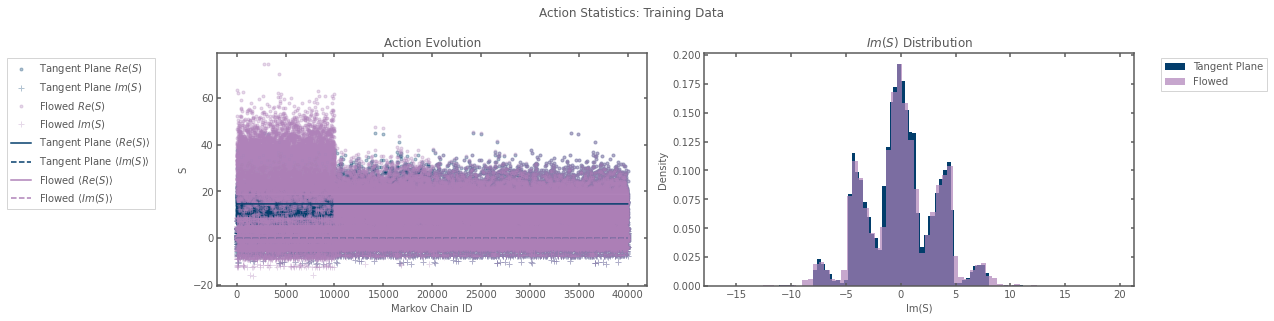

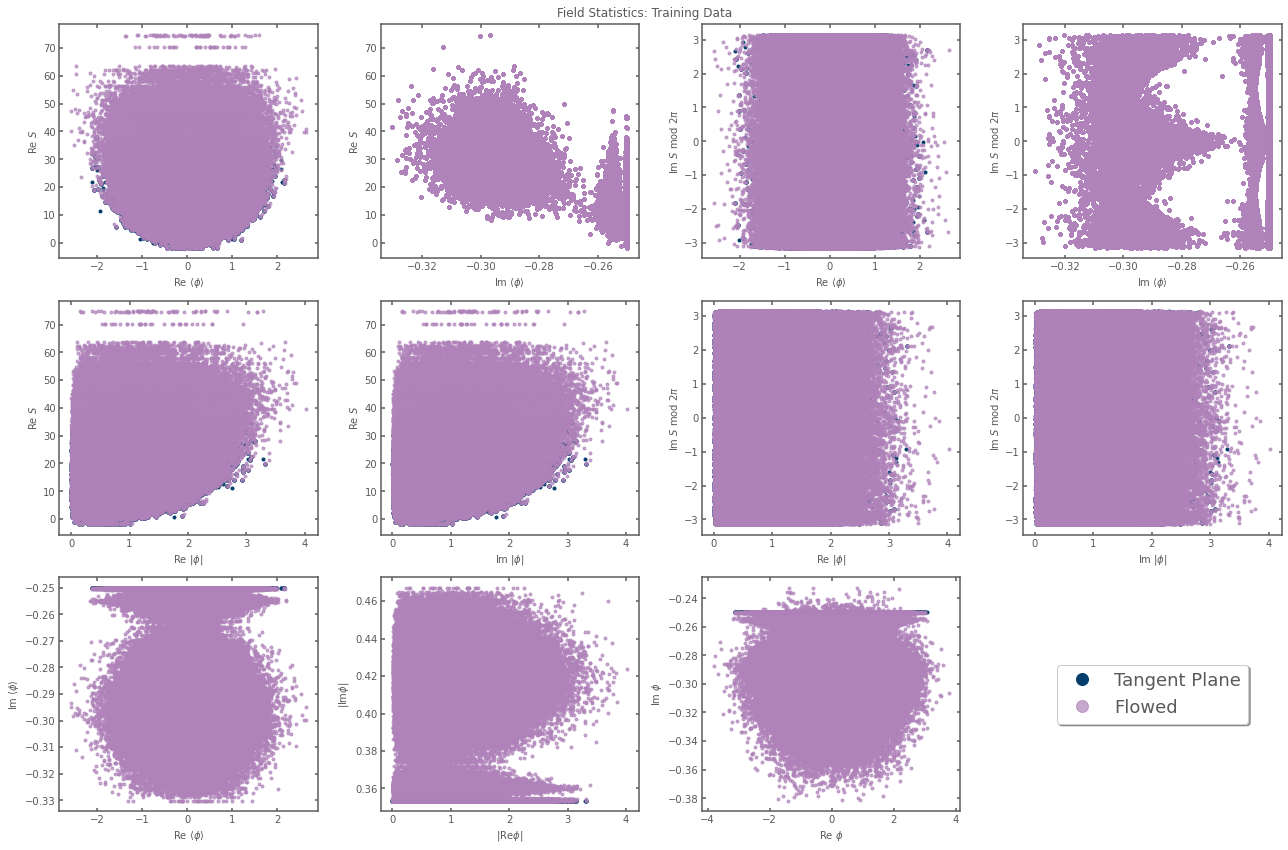

In [51]:
%%time
%matplotlib inline

# Flowed confs
fig_phys,fig_stat = field_statistic(
    confs_I=dtSet[:][0], 
    confs_C=dtSet[:][1], 
    action_I=dtSet.getAction(slice(len(dtSet)))[0], 
    action_C=dtSet.getAction(slice(len(dtSet)))[1], 
    plot_layout_dict={"I str":"Tangent Plane", "C str":"Flowed", "title":"Training Data"}, 
    param=params,
    skip = 1 # only plot every skip'th action value in the evolution plot
)

fig_phys.savefig("2Site_TrainingDataActionStats.pdf")
fig_stat.savefig("2Site_TrainingDataFieldStats.pdf")

fig_phys.savefig("2Site_TrainingDataActionStats.png")
fig_stat.savefig("2Site_TrainingDataFieldStats.png")

In [43]:
#RealLinearTransformation, Coupling, Equivariance, PRCL, Sequential
def NN_factory(param):
    def param_factory():
        nn = []
        for _ in range(1,param['number_layers']):
            # NxLayer = Nx/2 = 1 
            L = RealLinearTransformation(Nt = param['nt'], Nx = 1)
            #torch.nn.init.zeros_(L.weight)
            #torch.nn.init.zeros_(L.bias)
            torch.nn.init.xavier_normal_(L.weight, torch.nn.init.calculate_gain('leaky_relu', 0.01))
            torch.nn.init.xavier_normal_(L.bias, torch.nn.init.calculate_gain('leaky_relu', 0.01))
        
            nn.append(L)
            nn.append(torch.nn.LeakyReLU())
        
        # end with a layer without followed activation
        L = RealLinearTransformation(Nt = param['nt'], Nx = 1)
        # torch.nn.init.zeros_(L.weight)
        torch.nn.init.zeros_(L.bias)
        torch.nn.init.xavier_normal_(L.weight)
        #torch.nn.init.xavier_normal_(L.bias)
        
        nn.append(L)
        return torch.nn.Sequential(*nn)
    
    def PRCL_factory():
        return PRCL(
            Nt = param['nt'], 
            Nx = 2, 
            coupling = Coupling(
                param_factory(),
                tangentPlaneOffset = param['tangent_plane'] -0.0457
            )
        ).to(torch_options['device']) 
    
    return Equivariance(PRCL_factory())

In [44]:
# For testing different hyperparameters comment the following in.
param_path = "ParameterFiles/2Site_flow1e-1.json"
params = read_params(param_path)

print(f"Read from {param_path}")
for key,val in params.asdict().items():
    print(f"{key: <15}: {val}")
    
# create model
model = Sequential([NN_factory(params)])
if torch_options['use_gpu']:
    model.to(torch_options['device'])

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = params['lr'])

# specify loss function
loss = torch.nn.L1Loss(reduction='mean')

print(model)

Read from ParameterFiles/2Site_flow1e-1.json
nt             : 32
lattice        : two_sites
beta           : 4.0
U              : 4.0
mu             : 3.0
tangent_plane  : -0.249966501
tau_f          : 0.1
lr             : 0.0005
epochs         : 100
mini_batches   : 1
number_layers  : 3
rng_seed       : 1075
exact_corr_path: ExactData/exact.two_sites.exp.nt128.beta4_0.U4_0.mu3_0.txt
volume         : 64
sigmaKappa     : -1
hopping        : HFAHopping.EXP
basis          : HFABasis.PARTICLE_HOLE
algorithm      : HFAAlgorithm.DIRECT_SINGLE
Sequential(
  (module_list): ModuleList(
    (0): Equivariance(
      (NN): PRCL(
        (coupling): Coupling(
          (NN): Sequential(
            (0): RealLinearTransformation()
            (1): LeakyReLU(negative_slope=0.01)
            (2): RealLinearTransformation()
            (3): LeakyReLU(negative_slope=0.01)
            (4): RealLinearTransformation()
          )
        )
      )
    )
  )
)


In [45]:
%%time
train_loss, valid_loss = train(
    train_dataLoader, 
    valid_dataLoader, 
    model, 
    optimizer, 
    loss, 
    params, 
    pbar = None, 
    torch_opt = torch_options
)

  0%|          | 0/100 [00:00<?, ?it/s]

Training epochs 00-09|    Train: Time = 18.39s, Loss = 1.4241e+00    |    Valid: Time = 1.89s, Loss = 1.1280e+00
Training epochs 10-19|    Train: Time = 19.35s, Loss = 3.7538e-01    |    Valid: Time = 1.93s, Loss = 3.3779e-01
Training epochs 20-29|    Train: Time = 19.90s, Loss = 1.9870e-01    |    Valid: Time = 1.96s, Loss = 1.6978e-01
Training epochs 30-39|    Train: Time = 18.83s, Loss = 1.0318e-01    |    Valid: Time = 1.88s, Loss = 7.5663e-02
Training epochs 40-49|    Train: Time = 18.35s, Loss = 6.7773e-02    |    Valid: Time = 1.89s, Loss = 4.5143e-02
Training epochs 50-59|    Train: Time = 18.33s, Loss = 6.2401e-02    |    Valid: Time = 1.82s, Loss = 4.0779e-02
Training epochs 60-69|    Train: Time = 18.40s, Loss = 6.0009e-02    |    Valid: Time = 1.86s, Loss = 3.7149e-02
Training epochs 70-79|    Train: Time = 18.15s, Loss = 5.5989e-02    |    Valid: Time = 1.87s, Loss = 3.1046e-02
Training epochs 80-89|    Train: Time = 18.23s, Loss = 5.3137e-02    |    Valid: Time = 1.83s, L

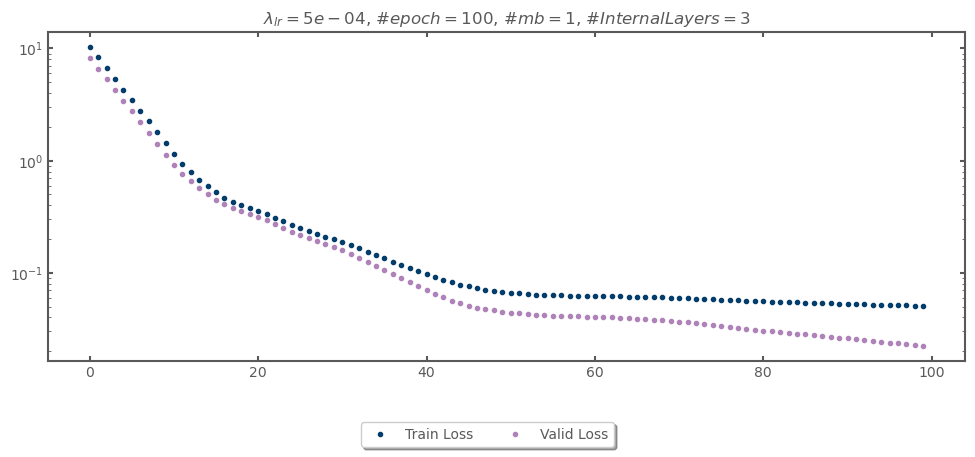

In [46]:
fig,axs = plt.subplots(1,1,figsize=(9.85,4))
plot_fn = get_fn("LossPlot","pdf",params)

train_h = axs.plot(np.arange(params['epochs']),train_loss,'.',color=BLUE,label = "Train Loss")
valid_h = axs.plot(np.arange(params['epochs']),valid_loss,'.',color=VIOLET,label = "Valid Loss")
    
axs.set_title(
     rf"$\lambda_{{lr}} = {params['lr']:.0e}$, "
    +rf"$\# epoch = {params['epochs']}$, "
    +rf"$\# mb = {params['mini_batches']}$, "
    +rf"$\# Internal Layers = {params['number_layers']}$"
)

axs.set_yscale('log')
        
train_l,valid_l = axs.get_legend_handles_labels()
fig.legend(train_l,valid_l,
loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol = 2
)
fig.tight_layout()

plt.savefig(plot_fn)

In [18]:
lossData_fn = get_fn("Losses","h5",params)

try:
    with h5.File(lossData_fn, 'a') as loss_file:
        loss_file.create_dataset(f"/lr{params['lr']}/epochs{params['epochs']}/mini_batches{params['mini_batches']}/number_layers{params['number_layers']}/train",
                            data=train_loss.numpy()
        ) 
        loss_file.create_dataset(f"/lr{params['lr']}/epochs{params['epochs']}/mini_batches{params['mini_batches']}/number_layers{params['number_layers']}/valid",
                            data=valid_loss.numpy()
        )
except(ValueError):
    print("Warning File Path already exists, not writing it")

In [19]:
model_fn = get_fn("ModelCheckpoint","pt",params)

torch.save({
        "model state":model.state_dict(),
        "optimizer state": optimizer.state_dict()
    },
    model_fn
)

load the model for evaluation or further training with 

```
checkpoint = torch.load(get_fn("ModelCheckpoint","pt",params))

model = Sequential([PRACL_factory(params) for _ in range(params['number_layers'])])
if torch_options['use_gpu']:
    model.to(torch_options['device'])

model.load_state_dict(checkpoint['model state'])
optimizer = torch.optim.Adam(model.parameters(), lr = params['lr'])
optimizer.load_state_dict(checkpoint['optimizer state'])

model.eval()
# or
# model.train()
```

In [13]:
checkpoint = torch.load(get_fn("ModelCheckpoint","pt",params))

model = Sequential([NN_factory(params)])
if torch_options['use_gpu']:
    model.to(torch_options['device'])

model.load_state_dict(checkpoint['model state'])
optimizer = torch.optim.Adam(model.parameters(), lr = params['lr'])
optimizer.load_state_dict(checkpoint['optimizer state'])

In [20]:
model.eval()

# isle is not set up to handle a gpu model, hence we ill need it on the cpu from now on.
if torch_options['use_gpu']:
    model.to(torch.device('cpu'))

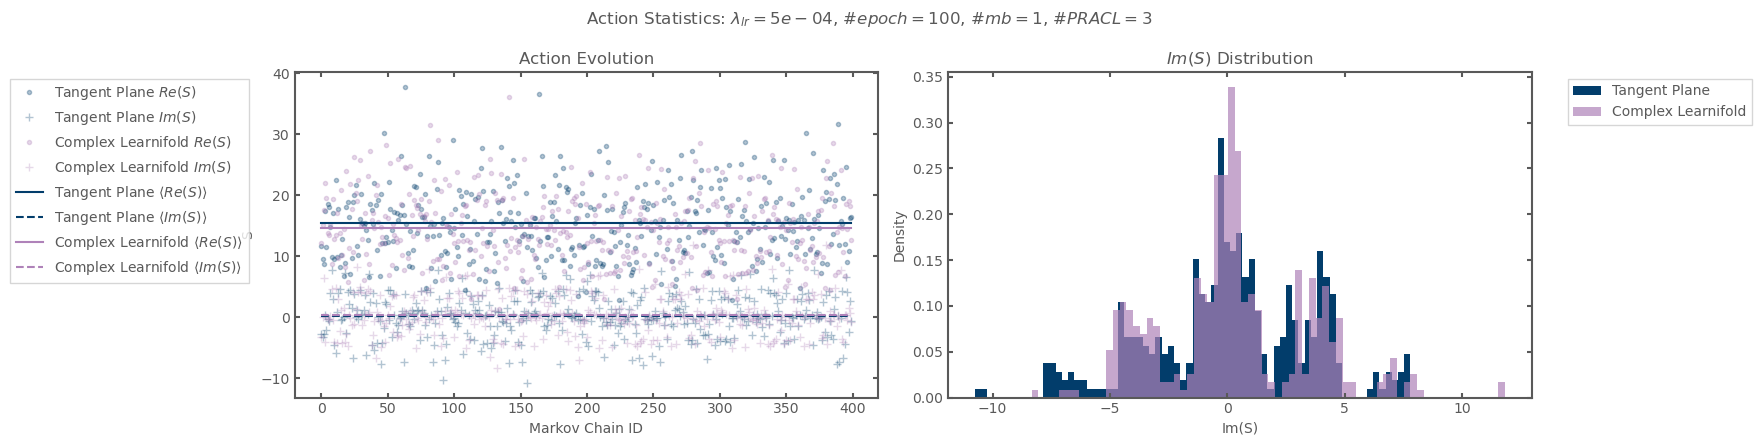

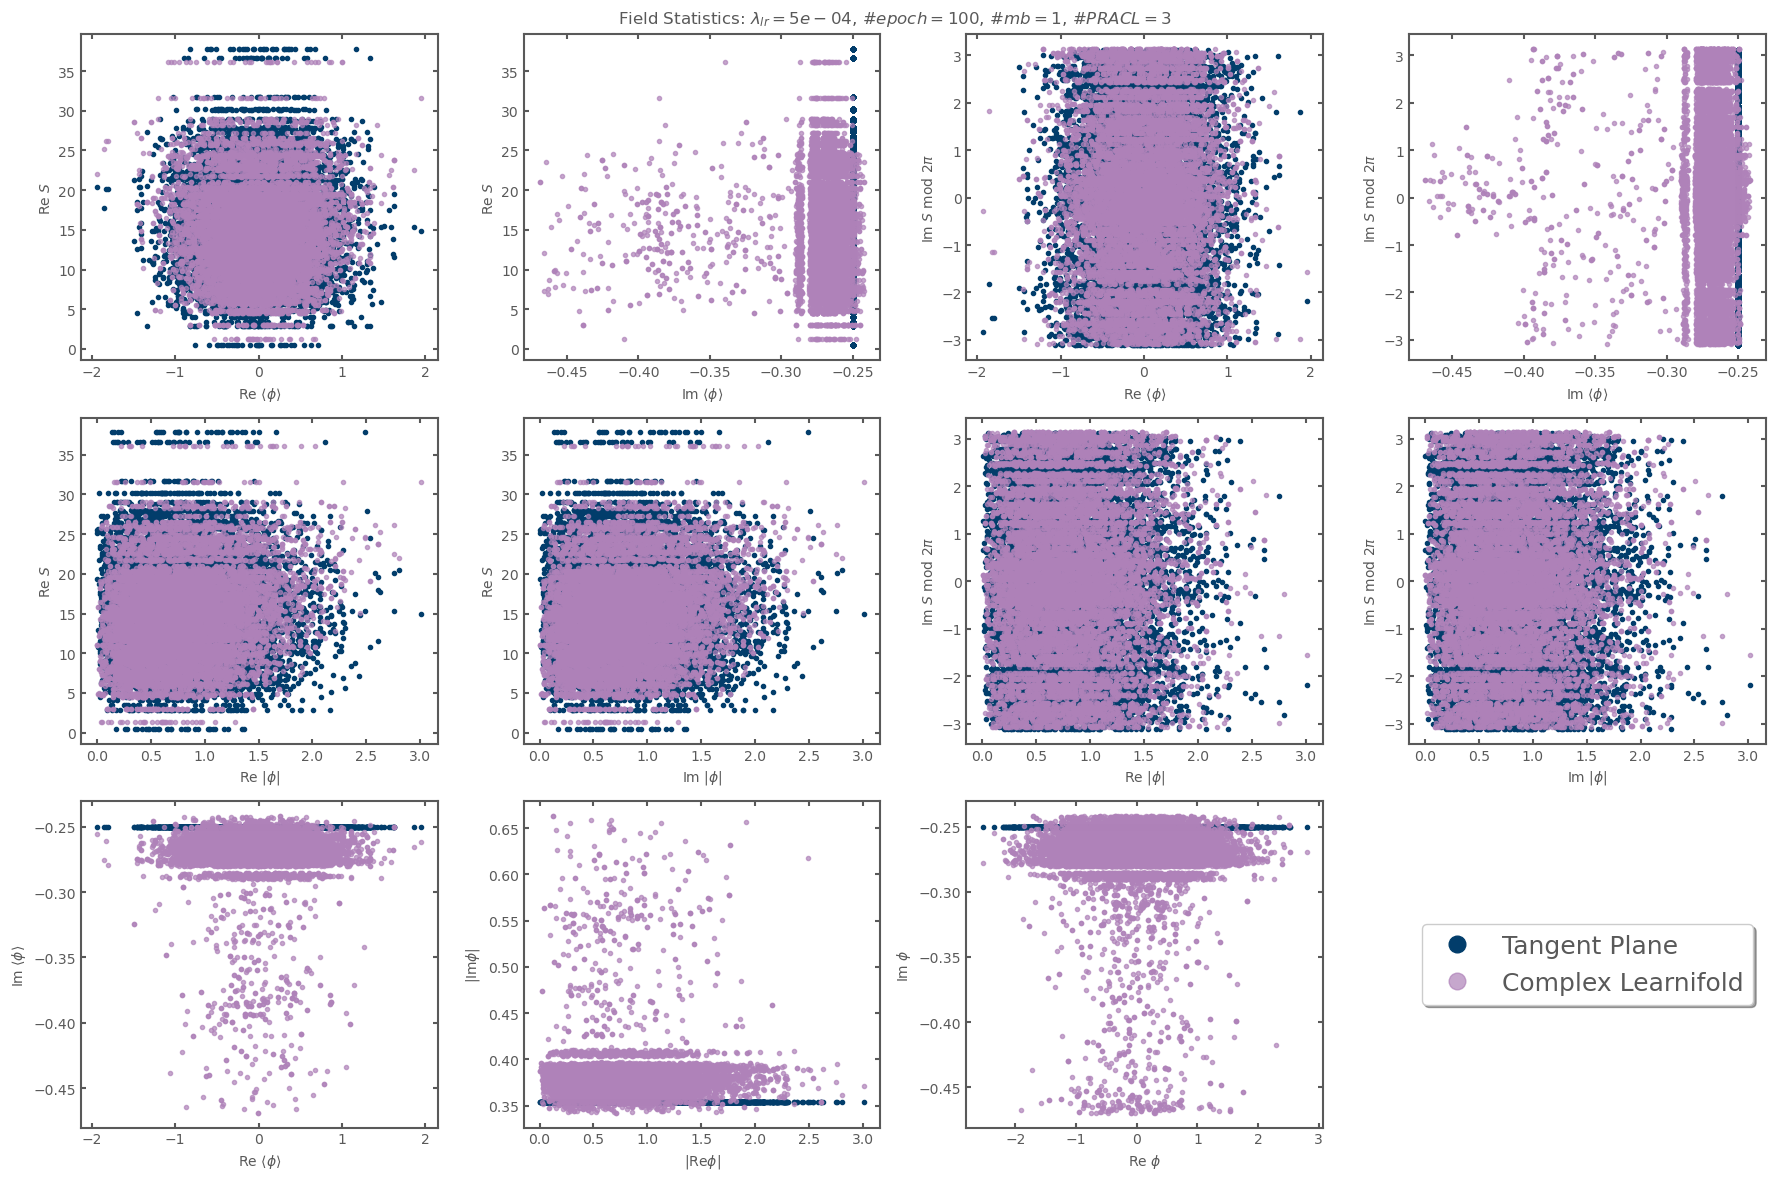

In [58]:
%%time
lattice = isle.LATTICES[params['lattice']]
lattice.nt(params['nt'])
action = make_action(lattice, params)
    
# Prepare configurations
confs_I = dtSet[::100][0]

# confs_I = confs_I[::100]

with torch.no_grad():
    confs_C,logDetJ = model(confs_I)

# prepare actions
action_I = dtSet.getAction(slice(len(confs_I)))[0] 
action_C = torch.tensor([
    action.eval(
        isle.CDVector(confs_C[i].reshape(params['nt']*2).numpy())
    ) for i in range(len(confs_C))
])
    
# plot field statistics for this model
fig_phys,fig_stat = field_statistic(
    confs_I=confs_I, 
    confs_C=confs_C, 
    action_I=action_I, 
    action_C=action_C, 
    plot_layout_dict={"I str":"Tangent Plane", 
                      "C str":"Complex Learnifold", 
                      "title": rf"$\lambda_{{lr}} = {params['lr']:.0e}$, "
                              +rf"$\# epoch = {params['epochs']}$, "
                              +rf"$\# mb = {params['mini_batches']}$, "
                              +rf"$\# PRACL = {params['number_layers']}$"
    }, 
    param=params,
    skip = 1 # only plot every skip'th action value in the evolution plot
)

fig_phys.savefig(get_fn("TrainedModelOutputActionStats","pdf",params))
fig_stat.savefig(get_fn("TrainedModelOutputFieldStats","pdf",params))

fig_phys.savefig(get_fn("TrainedModelOutputActionStats","png",params))
fig_stat.savefig(get_fn("TrainedModelOutputFieldStats","png",params))

In [22]:
# # perform the simulation with standard HMC
# f=Path(get_fn("HMC_Simulation","h5",params))
# if f.exists():
#     f.unlink()
    
# model_params = params.asdict()
# # set number of molecular dynamics step 
# model_params['MD_steps'] = 4
# # set molecular dynamics trajectory length
# model_params['MD_trajectory_length'] = 1.5
# model_params['nTraj'] = 1_000_000
# model_params['bTherm'] = 1_000
# model_params['sTherm'] = 10

# model_params = isle.util.parameters(**model_params)
# HMC(model_params)

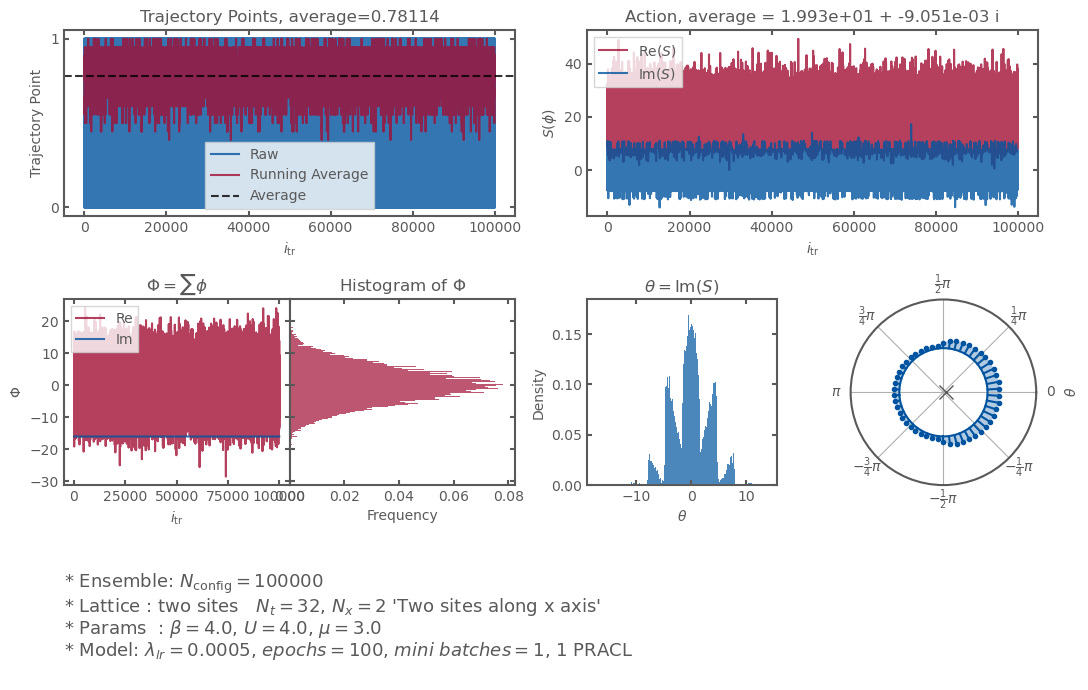

In [23]:
# fig = overview(get_fn("HMC_Simulation","h5",params))

fig = overview("Results/2Site_HMC_Simulation.h5")
# fig.savefig("Results/2Site_HMCSimulationOverview.pdf")

In [24]:
# # measure_correlators("Results/2Site_HMC_Simulation.h5",model_params)
# measure_correlators(get_fn("HMC_Simulation","h5",params),model_params)

In [61]:
# perform the simulation with ML HMC
f=Path(get_fn("MLHMC_Simulation","h5",params))
if f.exists():
    f.unlink()
    
model_params = params.asdict()
# set number of molecular dynamics step 
model_params['MD_steps'] = 4
# set molecular dynamics trajectory length
model_params['MD_trajectory_length'] = 1.5
model_params['nTraj'] = 1_000_000
model_params['bTherm'] = 1_000
model_params['sTherm'] = 10

model_params = isle.util.parameters(**model_params)
ML_HMC(model, model_params)

HMC evolution  ETA: ??:??:?? (   1/1000) 
HMC evolution  ETA: 08:07:22 (  10/1000) 
HMC evolution  ETA: 08:07:22 (  20/1000) 
HMC evolution  ETA: 08:07:22 (  30/1000) 
HMC evolution  ETA: 08:07:22 (  40/1000) 
HMC evolution  ETA: 08:07:22 (  50/1000) 
HMC evolution  ETA: 08:07:22 (  60/1000) 
HMC evolution  ETA: 08:07:22 (  70/1000) 
HMC evolution  ETA: 08:07:22 (  80/1000) 
HMC evolution  ETA: 08:07:22 (  90/1000) 
HMC evolution  ETA: 08:07:22 ( 100/1000) 
HMC evolution  ETA: 08:07:22 ( 110/1000) 
HMC evolution  ETA: 08:07:22 ( 120/1000) 
HMC evolution  ETA: 08:07:22 ( 130/1000) 
HMC evolution  ETA: 08:07:22 ( 140/1000) 
HMC evolution  ETA: 08:07:22 ( 150/1000) 
HMC evolution  ETA: 08:07:22 ( 160/1000) 
HMC evolution  ETA: 08:07:22 ( 170/1000) 
HMC evolution  ETA: 08:07:22 ( 180/1000) 
HMC evolution  ETA: 08:07:22 ( 190/1000) 
HMC evolution  ETA: 08:07:22 ( 200/1000) 
HMC evolution  ETA: 08:07:22 ( 210/1000) 
HMC evolution  ETA: 08:07:22 ( 220/1000) 
HMC evolution  ETA: 08:07:22 ( 230

HMC evolution  ETA: 08:27:30 ( 820000/1000000) 
HMC evolution  ETA: 08:27:30 ( 830000/1000000) 
HMC evolution  ETA: 08:27:30 ( 840000/1000000) 
HMC evolution  ETA: 08:27:30 ( 850000/1000000) 
HMC evolution  ETA: 08:27:31 ( 860000/1000000) 
HMC evolution  ETA: 08:27:31 ( 870000/1000000) 
HMC evolution  ETA: 08:27:31 ( 880000/1000000) 
HMC evolution  ETA: 08:27:31 ( 890000/1000000) 
HMC evolution  ETA: 08:27:31 ( 900000/1000000) 
HMC evolution  ETA: 08:27:31 ( 910000/1000000) 
HMC evolution  ETA: 08:27:32 ( 920000/1000000) 
HMC evolution  ETA: 08:27:32 ( 930000/1000000) 
HMC evolution  ETA: 08:27:33 ( 940000/1000000) 
HMC evolution  ETA: 08:27:33 ( 950000/1000000) 
HMC evolution  ETA: 08:27:33 ( 960000/1000000) 
HMC evolution  ETA: 08:27:34 ( 970000/1000000) 
HMC evolution  ETA: 08:27:34 ( 980000/1000000) 
HMC evolution  ETA: 08:27:34 ( 990000/1000000) 
HMC evolution  ETA: 08:27:34 (1000000/1000000) 
HMC evolution finished after 1212.9s at 08:27:34 


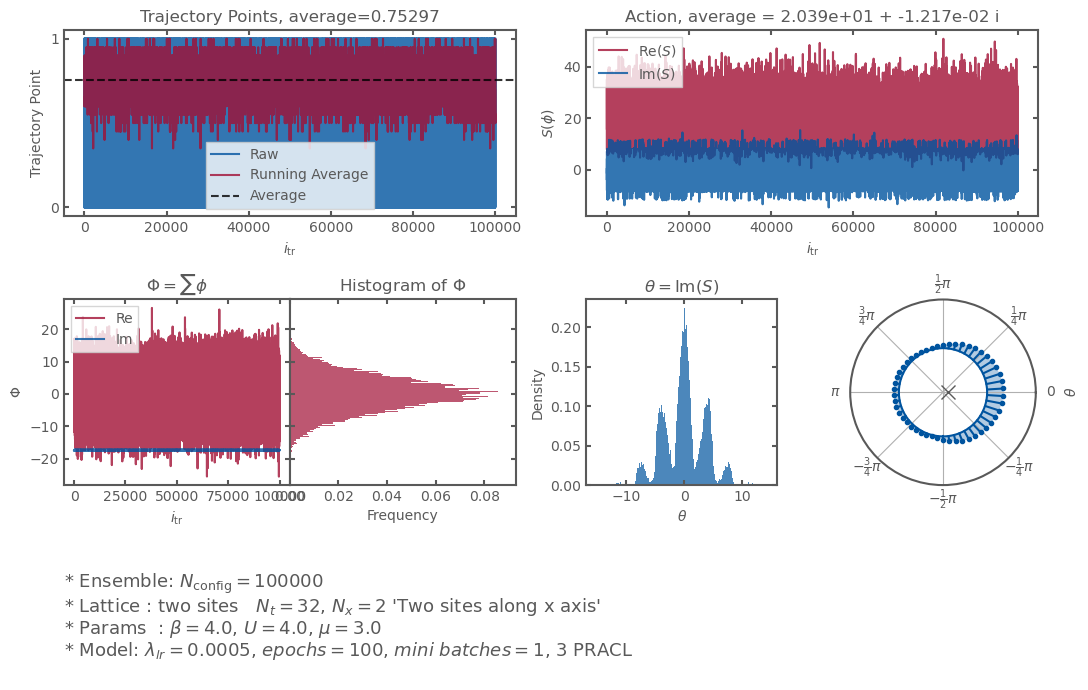

In [62]:
fig = overview(Path(get_fn("MLHMC_Simulation","h5",params)))
fig.savefig(get_fn("MLHMCSimulationOverview","pdf",params))

In [63]:
measure_correlators(get_fn("MLHMC_Simulation","h5",model_params),model_params)

Measurements  ETA: ??:??:?? (     1/100000) 
Measurements  ETA: 08:38:00 (  1000/100000) 
Measurements  ETA: 08:37:55 (  2000/100000) 
Measurements  ETA: 08:37:52 (  3000/100000) 
Measurements  ETA: 08:37:51 (  4000/100000) 
Measurements  ETA: 08:37:51 (  5000/100000) 
Measurements  ETA: 08:37:50 (  6000/100000) 
Measurements  ETA: 08:37:50 (  7000/100000) 
Measurements  ETA: 08:37:50 (  8000/100000) 
Measurements  ETA: 08:37:50 (  9000/100000) 
Measurements  ETA: 08:37:50 ( 10000/100000) 
Measurements  ETA: 08:37:50 ( 11000/100000) 
Measurements  ETA: 08:37:50 ( 12000/100000) 
Measurements  ETA: 08:37:50 ( 13000/100000) 
Measurements  ETA: 08:37:49 ( 14000/100000) 
Measurements  ETA: 08:37:49 ( 15000/100000) 
Measurements  ETA: 08:37:49 ( 16000/100000) 
Measurements  ETA: 08:37:50 ( 17000/100000) 
Measurements  ETA: 08:37:50 ( 18000/100000) 
Measurements  ETA: 08:37:50 ( 19000/100000) 
Measurements  ETA: 08:37:51 ( 20000/100000) 
Measurements  ETA: 08:37:52 ( 21000/100000) 
Measuremen

In [64]:
def estimate_correlators(fn, Nconf, Nbst = 100):
    with h5.File(fn,'r') as h5f:
        actVals = h5f["weights/actVal"][()][:Nconf]
        
        try:
            logDetJ = h5f["weights/logdetJ"][()][:Nconf]
        except(KeyError):
            logDetJ = np.zeros_like(actVals)
            
        Corr = h5f["correlation_functions/single_particle/destruction_creation"][()][:Nconf,:,:,:]
        Corr[:,:,:,1:-1:-1] += h5f["correlation_functions/single_particle/creation_destruction"][()][:Nconf,:,:,1:-1:-1]
        Corr[:,:,:,1:-1:-1] /= 2
        
        _,Nx,_,Nt = Corr.shape
        
        weights = np.exp(-1j*(actVals-logDetJ).imag)
        
        Corr *= weights[:,None,None,None]
        
        Corr_est = np.zeros( shape=(Nbst, Nx, Nt), dtype = complex )
        Stat_est = np.zeros( Nbst )
        
        for k in range(Nbst):
            idx = np.random.randint( low=0,high=Nconf, size=Nconf)
            stat = weights[idx].mean(axis=0)
            Stat_est[k] = np.abs(stat)
            Corr_est[k,0,:] = Corr[idx,0,0,:].mean(axis=0)/stat
            Corr_est[k,1,:] = Corr[idx,1,1,:].mean(axis=0)/stat
        return {
            "Corr": [Corr_est.mean(axis=0), Corr_est.std(axis=0)],
            "StatPower": [Stat_est.mean(axis=0), Stat_est.std(axis=0)]
        }

In [65]:
%%time
HMC_res1000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 1_000, Nbst = 100)

CPU times: user 36.6 ms, sys: 89.1 ms, total: 126 ms
Wall time: 126 ms


In [66]:
%%time
HMC_res10000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 10_000, Nbst = 100)

CPU times: user 414 ms, sys: 76.4 ms, total: 491 ms
Wall time: 490 ms


In [67]:
%%time
HMC_res100000 = estimate_correlators(fn = "Results/2Site_HMC_Simulation.h5", Nconf = 100_000, Nbst = 100)

CPU times: user 4.1 s, sys: 83.1 ms, total: 4.18 s
Wall time: 4.19 s


In [68]:
%%time
MLHMC_res1000 = estimate_correlators(fn = get_fn("MLHMC_Simulation","h5",model_params), Nconf = 1_000, Nbst = 100)

CPU times: user 43.3 ms, sys: 76.5 ms, total: 120 ms
Wall time: 119 ms


In [69]:
%%time
MLHMC_res10000 = estimate_correlators(fn = get_fn("MLHMC_Simulation","h5",model_params), Nconf = 10_000, Nbst = 100)

CPU times: user 381 ms, sys: 86.4 ms, total: 468 ms
Wall time: 469 ms


In [70]:
%%time
MLHMC_res100000 = estimate_correlators(fn = get_fn("MLHMC_Simulation","h5",model_params), Nconf = 100_000, Nbst = 100)

CPU times: user 4.07 s, sys: 73.2 ms, total: 4.15 s
Wall time: 4.15 s


In [71]:
print(f"Stat Power HMC 1_000  : {HMC_res1000['StatPower'][0]:.2e} +/- {HMC_res1000['StatPower'][1]:.2e}")
print(f"Stat Power HMC 10_000 : {HMC_res10000['StatPower'][0]:.2e} +/- {HMC_res10000['StatPower'][1]:.2e}")
print(f"Stat Power HMC 100_000: {HMC_res100000['StatPower'][0]:.2e} +/- {HMC_res100000['StatPower'][1]:.2e}")

Stat Power HMC 1_000  : 5.89e-02 +/- 1.94e-02
Stat Power HMC 10_000 : 5.39e-02 +/- 7.06e-03
Stat Power HMC 100_000: 5.54e-02 +/- 2.02e-03


In [72]:
print(f"Stat Power MLHMC 1_000  : {MLHMC_res1000['StatPower'][0]:.2e} +/- {MLHMC_res1000['StatPower'][1]:.2e}")
print(f"Stat Power MLHMC 10_000 : {MLHMC_res10000['StatPower'][0]:.2e} +/- {MLHMC_res10000['StatPower'][1]:.2e}")
print(f"Stat Power MLHMC 100_000: {MLHMC_res100000['StatPower'][0]:.2e} +/- {MLHMC_res100000['StatPower'][1]:.2e}")

Stat Power MLHMC 1_000  : 8.85e-02 +/- 2.26e-02
Stat Power MLHMC 10_000 : 1.11e-01 +/- 7.63e-03
Stat Power MLHMC 100_000: 1.02e-01 +/- 2.19e-03


In [73]:
  with h5.File("ExactData/exactData.h5") as h5f:
    node = f"{params['lattice']}/beta{params['beta']}/U{params['U']}/mu{params['mu']}"
    if node in h5f:
        tau = h5f["tau"][()]
        exactCorr = h5f[node][()]

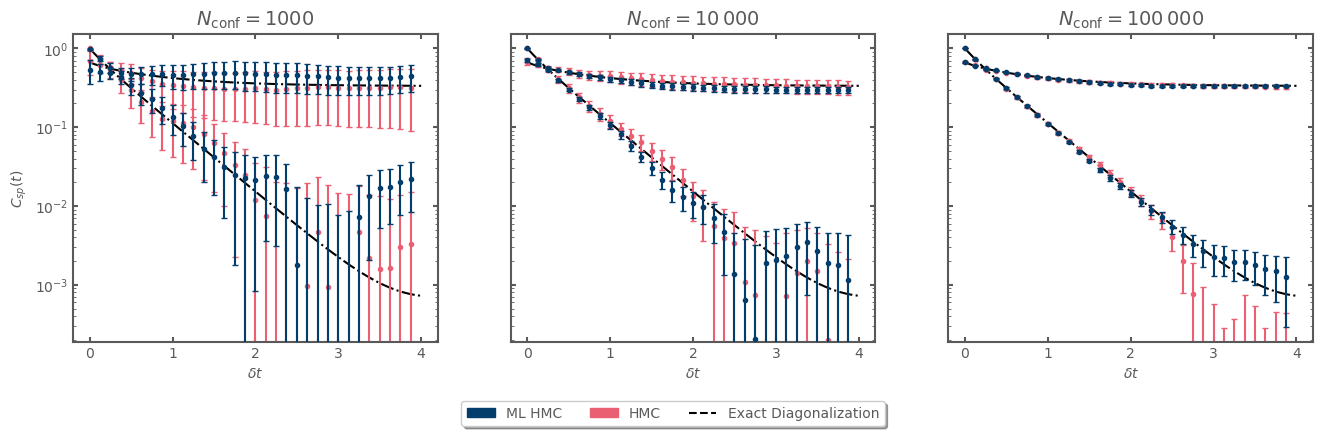

In [74]:
fig, axs = plt.subplots(1,3, figsize = (16,4),sharey = True)

simtau = np.arange(0,params['beta'],params['beta']/params['nt'])

for i in range(2):
    axs[0].errorbar(
        simtau,HMC_res1000["Corr"][0][i,:].real, yerr=HMC_res1000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )    
    axs[0].errorbar(
        simtau,MLHMC_res1000["Corr"][0][i,:].real, yerr=MLHMC_res1000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[0].plot(
        tau, exactCorr[i], 'k-.', zorder=1
    )
    
    axs[1].errorbar(
        simtau,HMC_res10000["Corr"][0][i,:].real, yerr=HMC_res10000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )    
    axs[1].errorbar(
        simtau,MLHMC_res10000["Corr"][0][i,:].real, yerr=MLHMC_res10000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[1].plot(
        tau, exactCorr[i], 'k-.',zorder=1
    )
    
    axs[2].errorbar(
        simtau,HMC_res100000["Corr"][0][i,:].real, yerr=HMC_res100000["Corr"][1][i,:], fmt = '.', capsize=2,color = RED,zorder=2
    )
    axs[2].errorbar(
        simtau,MLHMC_res100000["Corr"][0][i,:].real, yerr=MLHMC_res100000["Corr"][1][i,:], fmt = '.', capsize=2,color = BLUE,zorder=3
    )
    axs[2].plot(
        tau, exactCorr[i], 'k-.',zorder=1
    )

patch_1 = mpatches.Patch(color = BLUE,label = r"ML HMC")
patch_2 = mpatches.Patch(color = RED,label = r"HMC")
patch_3 = mlines.Line2D([], [], color = 'k', ls='--', label="Exact Diagonalization")

lgd = fig.legend(handles=[patch_1,patch_2,patch_3],
    loc='upper center', bbox_to_anchor=(0.5, -0.02),
    fancybox=True, shadow=True, ncol = 3
);

for ax in axs:
    ax.set_yscale('log')
    ax.set_xlabel(r"$\delta t$")

axs[0].set_ylabel(r"$C_{sp}(t)$");
axs[0].set_title("$N_{\mathrm{conf}} = 1000$", fontsize=14);
axs[1].set_title("$N_{\mathrm{conf}} = 10\, 000$", fontsize=14);
axs[2].set_title("$N_{\mathrm{conf}} = 100\, 000$", fontsize=14);


fig.savefig("Results/2Site_Correlators.pdf",
          bbox_extra_artists=(lgd,), 
          bbox_inches='tight'
)


In [75]:
def estimate_statistical_power(fn, Nconf, Nbst = 100):
    with h5.File(fn,'r') as h5f:
        actVals = h5f["weights/actVal"][()][:Nconf]
        
        try:
            logDetJ = h5f["weights/logdetJ"][()][:Nconf]
        except(KeyError):
            logDetJ = np.zeros_like(actVals)
        
        weights = np.exp(-1j*(actVals-logDetJ).imag)
e
        Stat_est = np.zeros( Nbst )
        
        for k in range(Nbst):
            idx = np.random.randint( low=0,high=Nconf, size=Nconf)

            Stat_est[k] = np.abs(weights[idx].mean(axis=0))

        return Stat_est.mean(axis=0), Stat_est.std(axis=0)

In [76]:
%%time
Nconfs = np.arange(1000,100_001,1000)
StatPowers_est = np.zeros(shape = (2,len(Nconfs)))
StatPowers_err = np.zeros(shape = (2,len(Nconfs)))
for i,Nconf in enumerate(Nconfs):
    StatPowers_est[0,i], StatPowers_err[0,i] = estimate_statistical_power(
        fn = "Results/2Site_HMC_Simulation.h5", 
        Nconf = Nconf, 
        Nbst = 100
    )
    StatPowers_est[1,i], StatPowers_err[1,i] = estimate_statistical_power(
        fn = get_fn("MLHMC_Simulation","h5",model_params), 
        Nconf = Nconf, 
        Nbst = 100
    )

CPU times: user 14.3 s, sys: 76.5 ms, total: 14.4 s
Wall time: 14.4 s


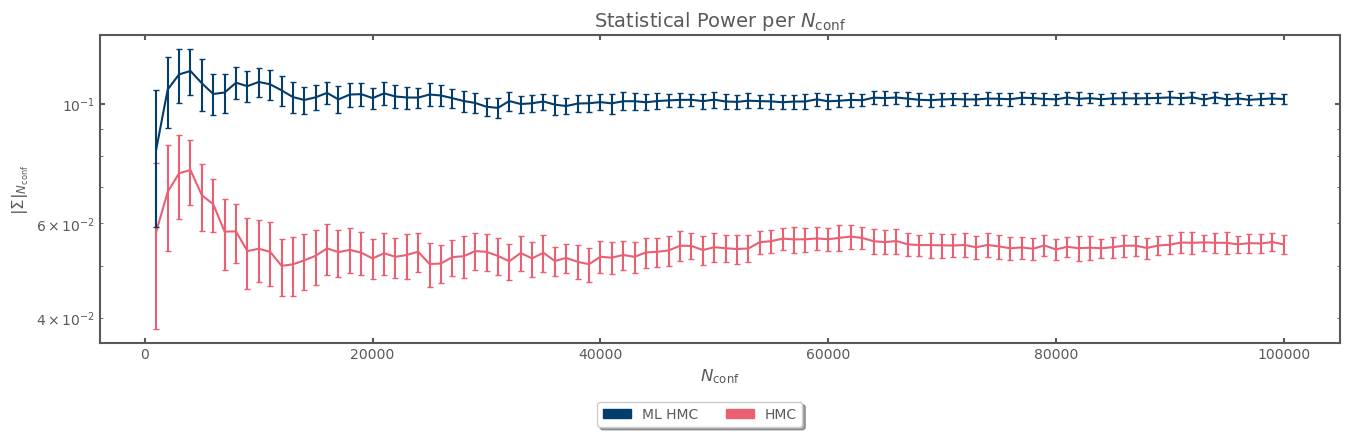

In [77]:
fig = plt.figure(figsize = (16,4) )
plt.errorbar(
    Nconfs, StatPowers_est[0], yerr = StatPowers_err[0], capsize = 2, color = RED ,zorder = 1
)
plt.errorbar(
    Nconfs, StatPowers_est[1], yerr = StatPowers_err[1], capsize = 2, color = BLUE ,zorder = 2
)
plt.yscale('log')
plt.ylabel(r"$\left\vert \Sigma \right\vert_{N_{\mathrm{conf}}}$", fontsize = 12)
plt.xlabel(r"$N_{\mathrm{conf}}$", fontsize = 12)
tit = plt.title(r"Statistical Power per $N_{\mathrm{conf}}$", fontsize = 14)
patch_1 = mpatches.Patch(color = BLUE,label = r"ML HMC")
patch_2 = mpatches.Patch(color = RED,label = r"HMC")
lgd = fig.legend(handles=[patch_1,patch_2],
    loc='upper center', bbox_to_anchor=(0.5, -0.02),
    fancybox=True, shadow=True, ncol = 2
);

fig.savefig("Results/Statpower.pdf",
          bbox_extra_artists=(lgd,tit), 
          bbox_inches='tight'
)
